In [1]:
%matplotlib inline

import os
from skimage import data, io, filters
import scipy.ndimage as ndimage
from skimage import color, img_as_float

from skimage.measure import compare_ssim as ssim
import skimage.measure as measure
from operator import itemgetter

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

/Users/vlandham/code/python/miniconda2/envs/pdf/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Much of this code comes from:
# http://stackoverflow.com/questions/4087919/how-can-i-improve-my-paw-detection
class BBox(object):
    '''
    Represents bounding box in image.
    Can be used to compare bounding boxes
    and extract image regions using the bounding box.

    '''
    def __init__(self, x1, y1, x2, y2):
        '''
        (x1, y1) is the upper left corner,
        (x2, y2) is the lower right corner,
        with (0, 0) being in the upper left corner.
        '''
        if x1 > x2: x1, x2 = x2, x1
        if y1 > y2: y1, y2 = y2, y1
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

    def width(self):
        '''
        Return width of bounding box
        '''
        return self.x2 - self.x1

    def height(self):
        '''
        Return height of bounding box
        '''
        return self.y2 - self.y1

    def x_extent(self):
        '''
        Return furthest x value of bounding box
        '''
        return self.x1 + self.width()

    def y_extent(self):
        '''
        Return furthest y value of bounding box
        '''
        return self.y1 + self.height()

    def extract(self, img):
        '''
        Extract sub-image from img where bounding box is
        '''
        return img[(self.y1 - 1):self.y_extent(), (self.x1 - 1):self.x_extent(), :]


    def taxicab_diagonal(self):
        '''
        Return the taxicab distance from (x1,y1) to (x2,y2)
        '''
        return self.x2 - self.x1 + self.y2 - self.y1

    def overlaps(self, other):
        '''
        Return True iff self and other overlap.
        '''
        return not ((self.x1 > other.x2)
                    or (self.x2 < other.x1)
                    or (self.y1 > other.y2)
                    or (self.y2 < other.y1))

    def __eq__(self, other):
        return (self.x1 == other.x1
                and self.y1 == other.y1
                and self.x2 == other.x2
                and self.y2 == other.y2)


def slice_to_bbox(slices):
    '''
    Convert skimage slices to BBoxes
    '''
    for s in slices:
        dy, dx = s[:2]
        yield BBox(dx.start, dy.start, dx.stop+1, dy.stop+1)


def remove_overlaps(bboxes):
    '''
    Return a set of BBoxes which contain the given BBoxes.
    When two BBoxes overlap, replace both with the minimal BBox that contains both.
    '''
    # list upper left and lower right corners of the Bboxes
    corners = []

    # list upper left corners of the Bboxes
    ulcorners = []

    # dict mapping corners to Bboxes.
    bbox_map = {}

    for bbox in bboxes:
        ul = (bbox.x1, bbox.y1)
        lr = (bbox.x2, bbox.y2)
        bbox_map[ul] = bbox
        bbox_map[lr] = bbox
        ulcorners.append(ul)
        corners.append(ul)
        corners.append(lr)

    # Use a KDTree so we can find corners that are nearby efficiently.
    tree = spatial.KDTree(corners)
    new_corners = []
    for corner in ulcorners:
        bbox = bbox_map[corner]
        # Find all points which are within a taxicab distance of corner
        indices = tree.query_ball_point(
            corner, bbox_map[corner].taxicab_diagonal(), p = 1)
        for near_corner in tree.data[indices]:
            near_bbox = bbox_map[tuple(near_corner)]
            if bbox != near_bbox and bbox.overlaps(near_bbox):
                # Expand both bboxes.
                # Since we mutate the bbox, all references to this bbox in
                # bbox_map are updated simultaneously.
                bbox.x1 = near_bbox.x1 = min(bbox.x1, near_bbox.x1)
                bbox.y1 = near_bbox.y1 = min(bbox.y1, near_bbox.y1)
                bbox.x2 = near_bbox.x2 = max(bbox.x2, near_bbox.x2)
                bbox.y2 = near_bbox.y2 = max(bbox.y2, near_bbox.y2)
    return set(bbox_map.values())


def remove_dups(bboxes):
    '''
    Remove duplicate BBoxes from a list of BBoxes
    '''
    clean_set = []
    for bbox in bboxes:
        if bbox not in clean_set:
            clean_set.append(bbox)
    return clean_set

def find_squares(bboxes, size=40, padding=10):
    '''
    Return filtered BBoxes list to include
    only BBoxes that are roughly square of size `size
    '''
    min_size = size - padding
    max_size = size + padding
    return [bbox for bbox in bboxes if (bbox.width() > min_size) and (bbox.width() < max_size) and (bbox.height() > min_size) and (bbox.height() < max_size)]

def find_img_match(img, imgs):
    '''
    Return index of most similar image in imgs to input img
    Uses: http://scikit-image.org/docs/dev/auto_examples/plot_ssim.html
    Code inspiration: http://www.pyimagesearch.com/2014/09/15/python-compare-two-images/
    '''
    ssims = []
    for bimg in imgs:
        # get images into same shape.
        shape = bimg.shape
        img_shaped = img[0:shape[0], 0:shape[1], :]
        shape = img_shaped.shape
        bimg_shaped = bimg[0:shape[0], 0:shape[1], :]

        score = ssim(img_shaped, bimg_shaped, multichannel=True)
        ssims.append(score)

    # find max score
    #max_ssim = max(ssims)
    (ind, max_ssim) = max(enumerate(ssims), key=itemgetter(1))

    out = {"index":ind, "score":max_ssim}

    #return (min_ssim, ind)
    return out



def convert_to_bw(img):
    '''
    Read in image from file,
    convert to pure Black only image
    '''

    #img = io.imread(filename, as_grey=False)
    #print(img.shape)


    fimg = img_as_float(img)

    filter_black = np.sum(fimg, axis=2)
    fimg_bw = fimg.copy()
    fimg_bw[(filter_black > 1)] = 1

    return fimg_bw


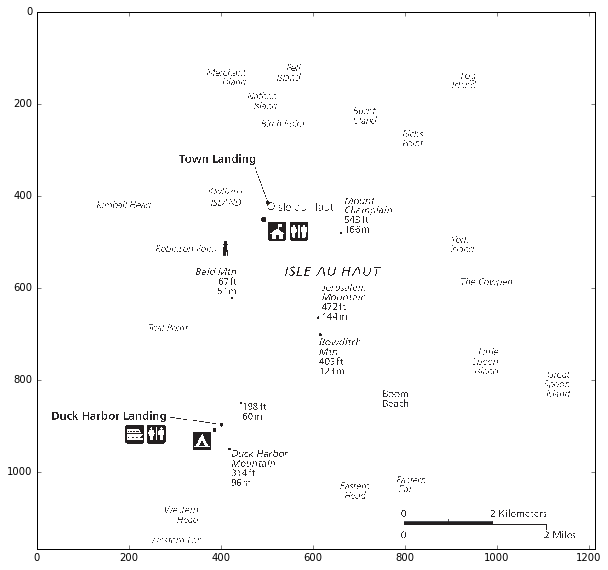

In [3]:
# Read image file in
filename = '../data/acadia-isle-au-haut-map.jpg'
img = io.imread(filename, as_grey=False)

#convert to only black and white
fimg_bw = convert_to_bw(img)


io.imshow(fimg_bw)



In [4]:
# invert color
fimg_bw_one = fimg_bw[:,:,1]
fimg_bw_one_invert = 1 - fimg_bw_one

# Use ndimage to find objects
labels, numobjects = ndimage.label(fimg_bw_one_invert)
slices = ndimage.find_objects(labels)

# Turn these found objects into
#  bboxes to work with them easier
bboxes = slice_to_bbox(slices)


In [5]:
# the slices seemed to be able to overlap, remove
# the overlap
bboxes = remove_dups(bboxes)
print('number of bboxes: ' + str(len(bboxes)))

# extract only square images
bboxes_filter = find_squares(bboxes)
print('number of square bboxes: ' + str(len(bboxes_filter)))

number of bboxes: 1646
number of square bboxes: 5


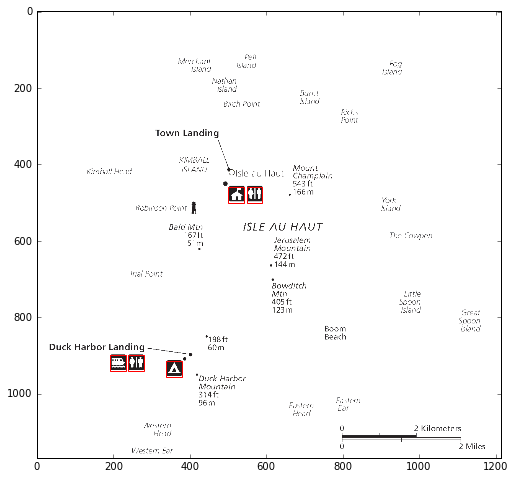

In [6]:
# view these boxes
import matplotlib.patches as patches
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(fimg_bw)    
for bbox in bboxes_filter:
    xwidth = bbox.x2 - bbox.x1
    ywidth = bbox.y2 - bbox.y1
    p = patches.Rectangle((bbox.x1, bbox.y1), bbox.width(), bbox.height(),
                          fc = 'none', ec = 'red')
    ax.add_patch(p)

In [7]:
# pull out the icons from our image
icons = [b.extract(fimg_bw) for b in bboxes_filter]


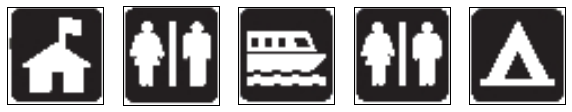

In [8]:
# display the icons
import math

fig = plt.figure()
width = 5
height = math.ceil(len(icons) / float(width))
#width = len(icons_filter) / 2
i = 1
for icon in icons:
    #ddd = fimg_bw[b.y1:b.y_extent(), b.x1:b.x_extent(), :]
    ax = fig.add_subplot(height,width,i)
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1
    im = ax.imshow(icon) 

In [9]:
# load icons to compare these to
import glob
def load_keys(key_dir):
    names = glob.glob(key_dir + "/icon_*_icon.png")
    imgs = []
    for path in names:
        img = io.imread(path)
        fname = path.split("/")[-1].split(".")[0]
        imgs.append({"name":fname, "path":path, "img":img_as_float(img)})
    return imgs


keys = load_keys('../data/icon_key')
key_images = [k['img'] for k in keys]
#print(keys[0])

In [10]:
# find best match for icons
matches = [find_img_match(icon, key_images) for icon in icons]

/Users/vlandham/code/python/miniconda2/envs/pdf/lib/python2.7/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/Users/vlandham/code/python/miniconda2/envs/pdf/lib/python2.7/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/Users/vlandham/code/python/miniconda2/envs/pdf/lib/python2.7/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/Users/vlandham/code/python/miniconda2/envs/pdf/lib/python2.7/site-packages/skimage/measure/_structural_similarity.py:

In [11]:
matches

[{'index': 3, 'score': 0.7274254138858901},
 {'index': 73, 'score': 0.71729605646269168},
 {'index': 44, 'score': 0.84054962589366899},
 {'index': 73, 'score': 0.81610355747532026},
 {'index': 20, 'score': 0.86759324234034718}]

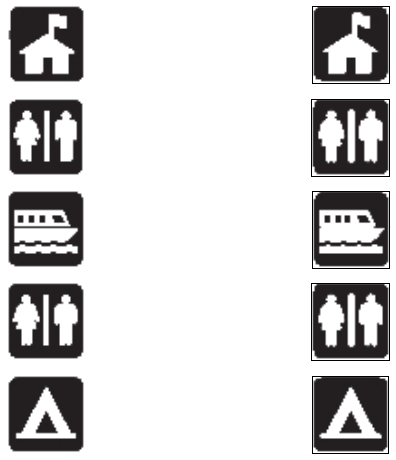

In [12]:
# display key matches with original icons
fig = plt.figure()
width = 2
height = len(icons)
i = 1
for ind, icon in enumerate(icons):
    #ddd = fimg_bw[b.y1:b.y_extent(), b.x1:b.x_extent(), :]
    ax = fig.add_subplot(height,width,i)
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1
    im = ax.imshow(icon) 
    plt.axis("off")
    ax = fig.add_subplot(height,width,i)
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1
    match = matches[ind]
    im = ax.imshow(key_images[match['index']]) 

IndexError: list index out of range

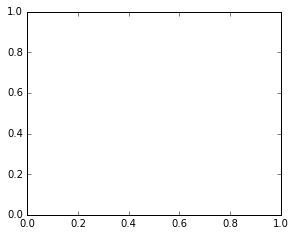

In [13]:
#print(match)
#io.imshow(key_imgs[match])

fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
plt.imshow(icons[10], cmap = plt.cm.gray)
plt.axis("off")

ax = fig.add_subplot(2, 2, 2)
plt.imshow(key_imgs[match], cmap = plt.cm.gray)
plt.axis("off")

ax = fig.add_subplot(2, 2, 3)
plt.imshow(icons[10], cmap = plt.cm.gray)
plt.axis("off")

ax = fig.add_subplot(2, 2, 4)
plt.imshow(key_imgs[match], cmap = plt.cm.gray)
plt.axis("off")
 
# show the imags
plt.savefig()